In [1]:
import rubrix as rb
import modAL
import sklearn
import pandas as pd

/Users/maxine/Library/Python/3.9/lib/python/site-packages/jose/backends/cryptography_backend.py:18: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


  0%|          | 0/1 [00:00<?, ?it/s]

1 records logged to http://localhost:6900/ws/rubrix/example-dataset


BulkResponse(dataset='example-dataset', processed=1, failed=0)

In [21]:
# If you are using the default installation you can skip this line
train_df = pd.read_csv("https://raw.githubusercontent.com/recognai/rubrix/master/docs/tutorials/data/yt_comments_train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/recognai/rubrix/master/docs/tutorials/data/yt_comments_test.csv")

In [22]:
train_df

,Unnamed: 0,author,date,text,label,video
0,0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1
...,...,...,...,...,...,...
1581,443,Themayerlife,NaN,Check out my mummy chanel!,-1.0,4
1582,444,Fill Reseni,2015-05-27T17:10:53.724000,The rap: cool Rihanna: STTUUPID﻿,-1.0,4
1583,445,Greg Fils Aimé,NaN,I hope everyone is in good spirits I&#39;m a h...,-1.0,4
1584,446,Lil M,NaN,Lil m !!!!! Check hi out!!!!! Does live the wa...,-1.0,4


In [23]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()


In [24]:
from modAL.models import ActiveLearner
learner = ActiveLearner(estimator=classifier,)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,5))

X_train = vectorizer.fit_transform(train_df.text)
X_test = vectorizer.transform(test_df.text) # not CONTENT as specified in docs

In [28]:
# Number of instances we want to annotate per iteration
n_instances = 10

# Accuracies after each iteration to keep track of our improvement
accuracies = []

In [37]:
from sklearn.exceptions import NotFittedError

# query examples from our training pool with the most uncertain prediction
query_idx, query_inst = learner.query(X_train, n_instances=n_instances)

# get predictions for the queried examples
try:
    probabilities = learner.predict_proba(X_train[query_idx])
# For the very first query we do not have any predictions
except NotFittedError:
    probabilities = [[0.5, 0.5]]*n_instances

In [38]:
import rubrix as rb

# Build the Rubrix records
records = [
    rb.TextClassificationRecord(
        id=idx,
        inputs=train_df.text.iloc[idx], # not CONTENT as in docs
        prediction=list(zip(["HAM", "SPAM"], probs)),
        prediction_agent="MultinomialNB",
    )
    for idx, probs in zip(query_idx, probabilities)
]

# Log the records
rb.log(records, name="active_learning_tutorial")

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/active_learning_tutorial


BulkResponse(dataset='active_learning_tutorial', processed=10, failed=0)

In [39]:
# Load the annotated records into a pandas DataFrame
records_df = rb.load("active_learning_tutorial", ids=query_idx.tolist())

# check if all examples were annotated
if any(records_df.annotation.isna()):
    raise UserWarning("Please annotate first all your samples before teaching the model")

# train the classifier with the newly annotated examples
y_train = records_df.annotation.map(lambda x: int(x == "SPAM"))
learner.teach(X=X_train[query_idx], y=y_train.to_list())

# Keep track of our improvement
accuracies.append(learner.score(X=X_test, y=test_df.label)) # not CLASS as in docs

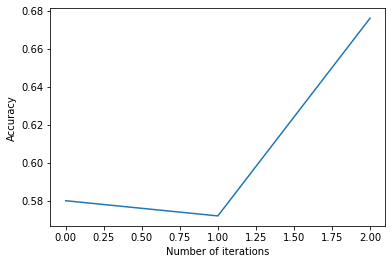

In [40]:
import matplotlib.pyplot as plt

# Plot the accuracy versus the iteration number
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy");